In [2]:

using Images
using Statistics
using LinearAlgebra
using MultivariateStats
function cargar_imagenes(carpeta)
    imagenes = []
    nombres_imagenes = []

    subcarpetas = readdir(carpeta)

    for subcarpeta in subcarpetas
        subcarpeta_ruta = joinpath(carpeta, subcarpeta)

        if isdir(subcarpeta_ruta)
            archivos = readdir(subcarpeta_ruta)

            for archivo in archivos
                if endswith(archivo, ".jpg")
                    ruta_completa = joinpath(subcarpeta_ruta, archivo)
                    imagen = load(ruta_completa)
                    imagen = Images.imresize(imagen, (100, 100) ) # Redimensionar a 30x30 píxeles
                    imagen = Gray.(imagen)  # Convertir a escala de grises
                    imagen = reinterpret(UInt8, imagen) 
                    print(length(imagen)) # Cambiar a 8 bits (UInt8)
        
                    push!(imagenes, imagen)
                    push!(nombres_imagenes, archivo) 
                end
            end
        end
    end

    return imagenes, nombres_imagenes
end



cargar_imagenes (generic function with 1 method)

In [3]:

# Cargar imágenes de entrenamiento desde la carpeta "faces" que contiene subcarpetas
imagenes_entrenamiento, nombres_entrenamiento = cargar_imagenes("faces")


# Armar la matriz de datos de entrenamiento
num_imagenes_entrenamiento = length(imagenes_entrenamiento)
matriz_de_datos_entrenamiento = zeros(UInt8, num_imagenes_entrenamiento, 100* 100)

for i in 1:num_imagenes_entrenamiento
    matriz_de_datos_entrenamiento[i, :] = reinterpret(UInt8, vec(imagenes_entrenamiento[i]))
end




40964096

40964096

40964096

4096409640964096

40964096409640964096409640964096

In [5]:
# Calcular la media y centrar los datos de entrenamiento
media_entrenamiento = mean!(transpose(ones(100*100)),matriz_de_datos_entrenamiento)
matriz_centralizada_entrenamiento = matriz_de_datos_entrenamiento .- media_entrenamiento

# Calcular la matriz de covarianza y los autovectores de entrenamiento
matriz_covarianza_entrenamiento = cov(matriz_centralizada_entrenamiento)
autovalores_entrenamiento, autovectores_entrenamiento = eigen(matriz_covarianza_entrenamiento)

# Ordenar autovectores en orden descendente de acuerdo a sus autovalores de entrenamiento
idx_entrenamiento = sortperm(-autovalores_entrenamiento)
autovalores_entrenamiento = autovalores_entrenamiento[idx_entrenamiento]
autovectores_entrenamiento = autovectores_entrenamiento[:, idx_entrenamiento]

# Definir el número de componentes a retener (ajusta según sea necesario) para entrenamiento
num_componentes_entrenamiento = 20
autovectores_entrenamiento = autovectores_entrenamiento[:, 1:num_componentes_entrenamiento]

# Calcular las proyecciones de entrenamiento y reconstrucciones de entrenamiento
proyecciones_entrenamiento = matriz_centralizada_entrenamiento * autovectores_entrenamiento
reconstrucciones_entrenamiento = proyecciones_entrenamiento * autovectores_entrenamiento' .+ media_entrenamiento
mse = sum(abs2.(matriz_de_datos_entrenamiento .- reconstrucciones_entrenamiento)) / size(matriz_de_datos_entrenamiento, 1)
println("Error Cuadrático Medio (MSE): ", mse)


Error Cuadrático Medio (MSE): 1.517899255422427e-22


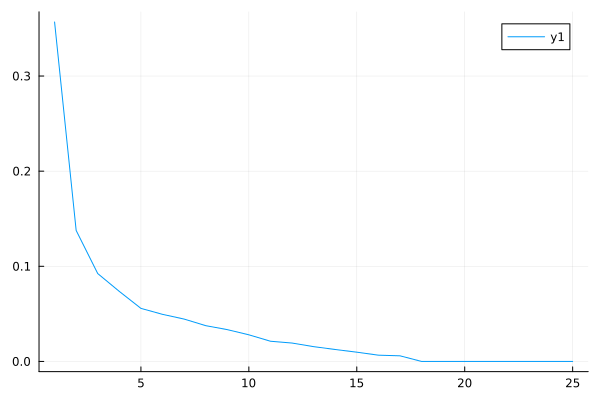

In [38]:


sorted_values=sort(autovalores_entrenamiento ,rev=true);
length(sorted_values)
using Plots;

sorted_values=sorted_values./sum(sorted_values)
plot(sorted_values[1:25])

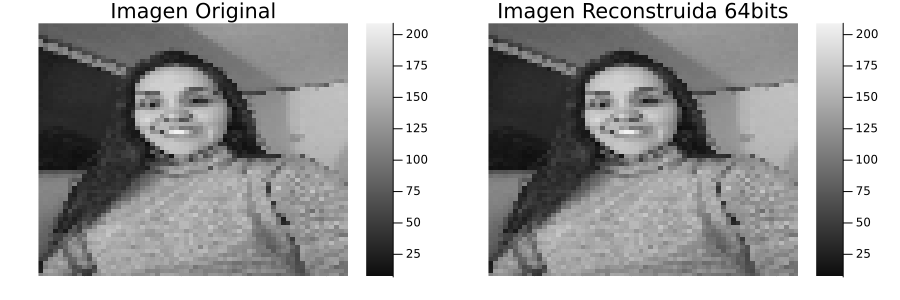

In [39]:
using Plots

# Índice de la imagen que deseas mostrar (ajusta según sea necesario)
indice_a_mostrar = 1# Cambia este índice para mostrar una imagen diferente

# Obtén la imagen original y su reconstrucción
imagen_original = reverse(reshape(matriz_de_datos_entrenamiento[indice_a_mostrar, :], 100, 100), dims=1)  # Ajusta el tamaño según tus imágenes y voltea verticalmente
imagen_reconstruida = reverse(reshape(reconstrucciones_entrenamiento[indice_a_mostrar, :], 100, 100), dims=1)  # Ajusta el tamaño según tus imágenes y voltea verticalmente

# Crea una figura con subfiguras para mostrar las imágenes
plot(
    heatmap(imagen_original, color=:grays, axis=false, title="Imagen Original"),
    heatmap(imagen_reconstruida, color=:grays, axis=false, title="Imagen Reconstruida 64bits"),
    layout=(1, 2),
    size=(900, 300)
)

In [34]:
# Prueba
# Cargar imágenes de prueba desde la carpeta "test"
imagenes_prueba, nombres_prueba = cargar_imagenes("faces/prueba")
# Armar la matriz de datos de prueba
num_imagenes_prueba = length(imagenes_prueba)
matriz_de_datos_prueba = zeros(Float64, num_imagenes_prueba, 100 * 100)

for i in 1:num_imagenes_prueba
    matriz_de_datos_prueba[i, :] = vec(imagenes_prueba[i])
end

# Calcular la proyección de cada imagen de prueba en el espacio de las componentes principales de entrenamiento
proyecciones_prueba = (matriz_de_datos_prueba .- media_entrenamiento) * autovectores_entrenamiento

# Inicializar un vector para almacenar las etiquetas predichas
etiquetas_predichas = []

# Inicializar un vector para almacenar las distancias mínimas
distancias_minimas = []

# Para cada imagen de prueba
for i in 1:num_imagenes_prueba
    distancia_minima = Inf
    etiqueta_predicha = ""

    # Calcular la distancia entre la proyección de la imagen de prueba y las proyecciones de entrenamiento
    for j in 1:num_imagenes_entrenamiento
        distancia = norm(proyecciones_prueba[i, :] - proyecciones_entrenamiento[j, :])
        
        # Almacenar la distancia mínima
        if distancia < distancia_minima
            distancia_minima = distancia
            etiqueta_predicha = nombres_entrenamiento[j]
        end
    end
    # Almacenar la etiqueta predicha y la distancia mínima
    push!(etiquetas_predichas, etiqueta_predicha)
    push!(distancias_minimas, distancia_minima)
end

# Imprimir las etiquetas predichas para las imágenes de prueba
println("Etiquetas Predichas: ", etiquetas_predichas)

# Imprimir las distancias mínimas para las imágenes de prueba
println("Distancias Mínimas: ", distancias_minimas[1])



In [40]:
indice_parecida = findfirst(nombres_entrenamiento .== etiquetas_predichas)
imagen_parecida = reverse(reshape(matriz_de_datos_entrenamiento[indice_parecida, :], 100, 100), dims=1)

64×64 Matrix{UInt8}:
 0x46  0x45  0x4d  0x3a  0x53  0x1a  …  0x3a  0x3d  0x4c  0x3b  0x50  0x4d
 0x5e  0x5e  0x47  0x52  0x3c  0x2f     0x41  0x3d  0x44  0x42  0x4d  0x47
 0x47  0x43  0x60  0x52  0x39  0x43     0x41  0x51  0x3a  0x45  0x4b  0x4b
 0x57  0x50  0x51  0x53  0x63  0x31     0x44  0x4b  0x47  0x4c  0x3b  0x4b
 0x5c  0x52  0x3b  0x58  0x55  0x52     0x44  0x39  0x45  0x56  0x43  0x50
 0x5b  0x64  0x4f  0x30  0x48  0x5b  …  0x3f  0x45  0x4f  0x44  0x41  0x53
 0x65  0x60  0x5b  0x64  0x58  0x59     0x66  0x46  0x53  0x3b  0x48  0x4d
 0x58  0x3d  0x5b  0x52  0x51  0x56     0x4f  0x55  0x51  0x45  0x4f  0x57
 0x5c  0x61  0x4f  0x44  0x5d  0x49     0x50  0x57  0x4d  0x49  0x48  0x5e
 0x53  0x62  0x5f  0x55  0x47  0x62     0x5c  0x52  0x41  0x47  0x64  0x61
    ⋮                             ⋮  ⋱                 ⋮              
 0x29  0x29  0x2b  0x29  0x27  0x28  …  0x33  0x39  0x3b  0x34  0x32  0x32
 0x2e  0x2b  0x2c  0x29  0x29  0x29     0x34  0x3b  0x35  0x34  0x35  0x35
 0x2a  0

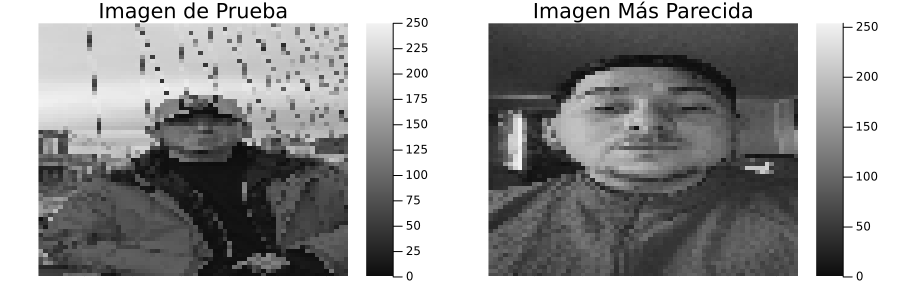

In [41]:
using Plots


imagen_original = reverse(reshape(matriz_de_datos_prueba, 100, 100), dims=1)  # Ajusta el tamaño según tus imágenes y voltea verticalmente
imagen_parecida = reverse(reshape(matriz_de_datos_entrenamiento[indice_parecida, :], 100, 100), dims=1)  # Ajusta el índice según la imagen más parecida

# Crea una figura con subfiguras para mostrar las imágenes
plot(
    heatmap(imagen_original, color=:grays, axis=false, title="Imagen de Prueba"),
    heatmap(imagen_parecida, color=:grays, axis=false, title="Imagen Más Parecida"),
    layout=(1, 2),
    size=(900, 300)
)